In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
df = pd.read_csv(os.path.join('data','MBTA_Monthly_Ridership_By_Mode_and_Line.csv'))

In [6]:
df.isna().sum()

month_of_service     0
daytype              0
daycount             0
route_or_line        0
ridership_total      0
ridership_average    0
ObjectId             0
dtype: int64

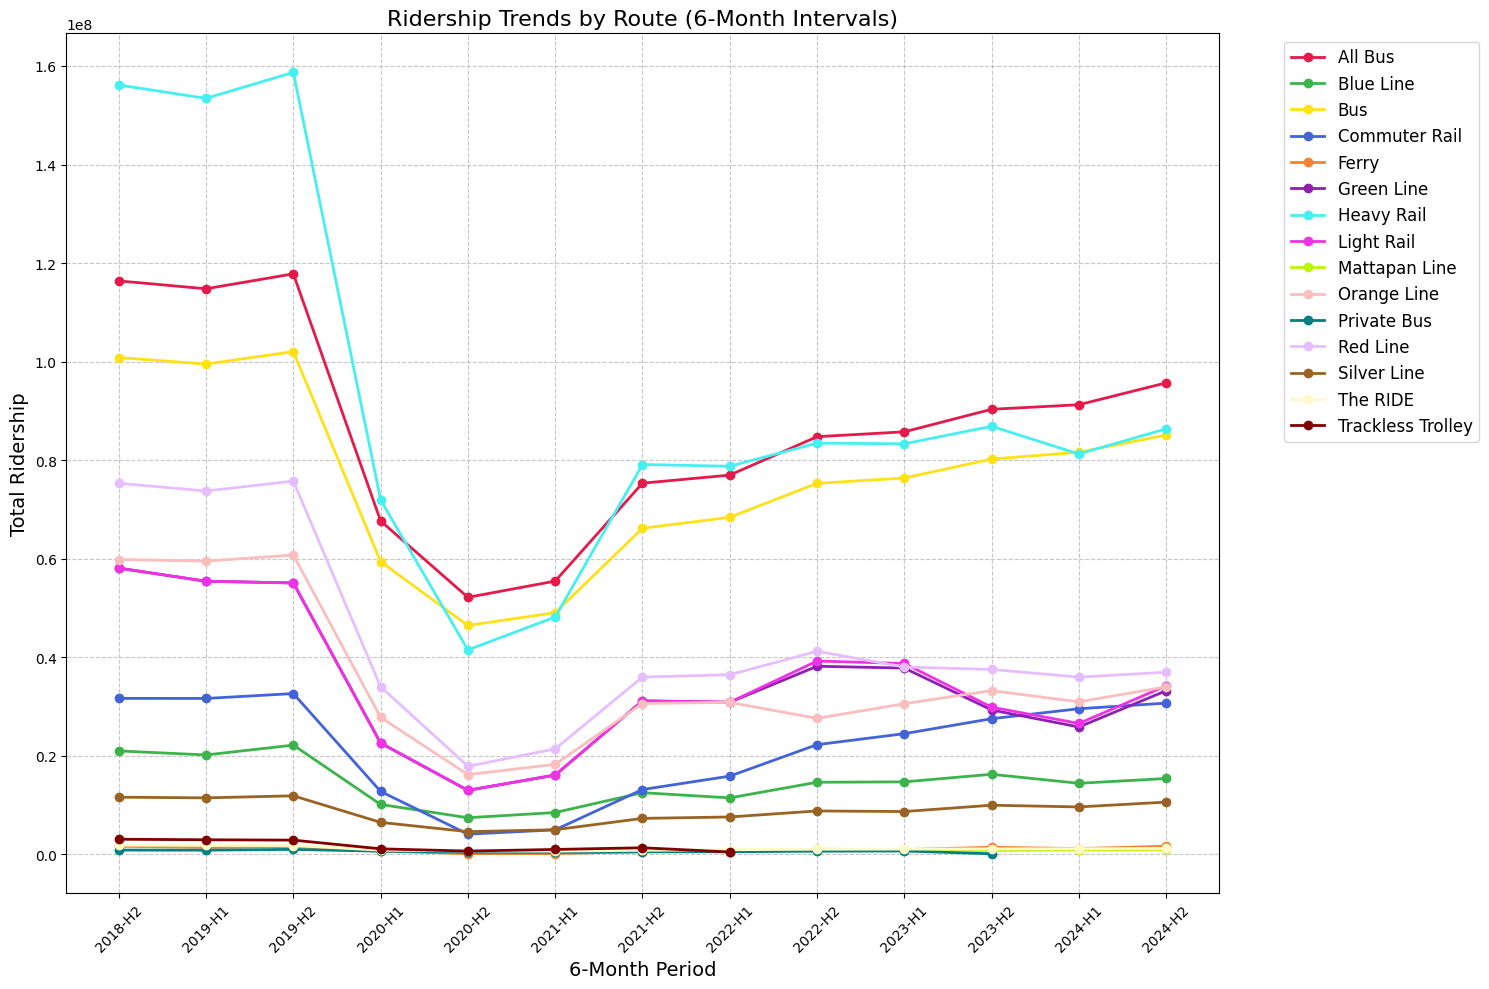

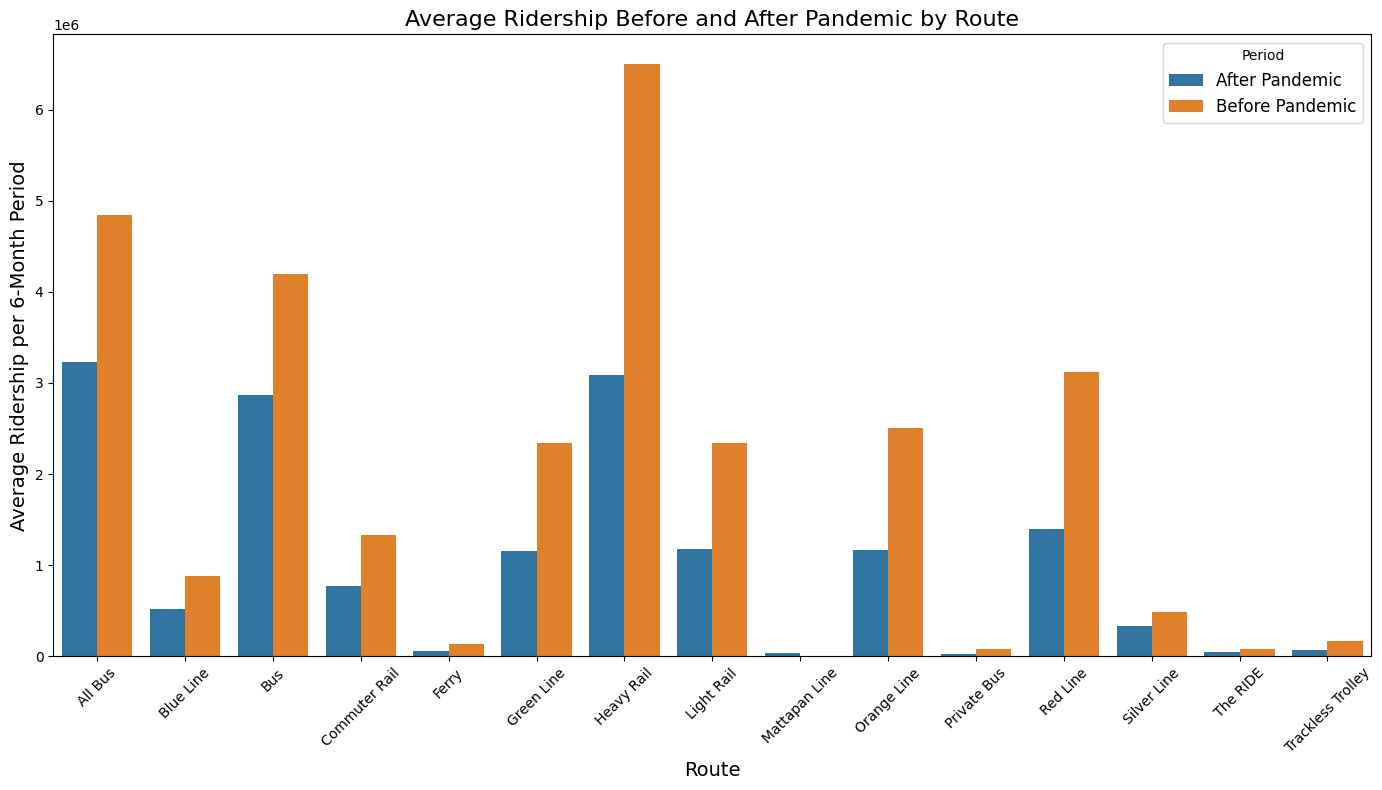

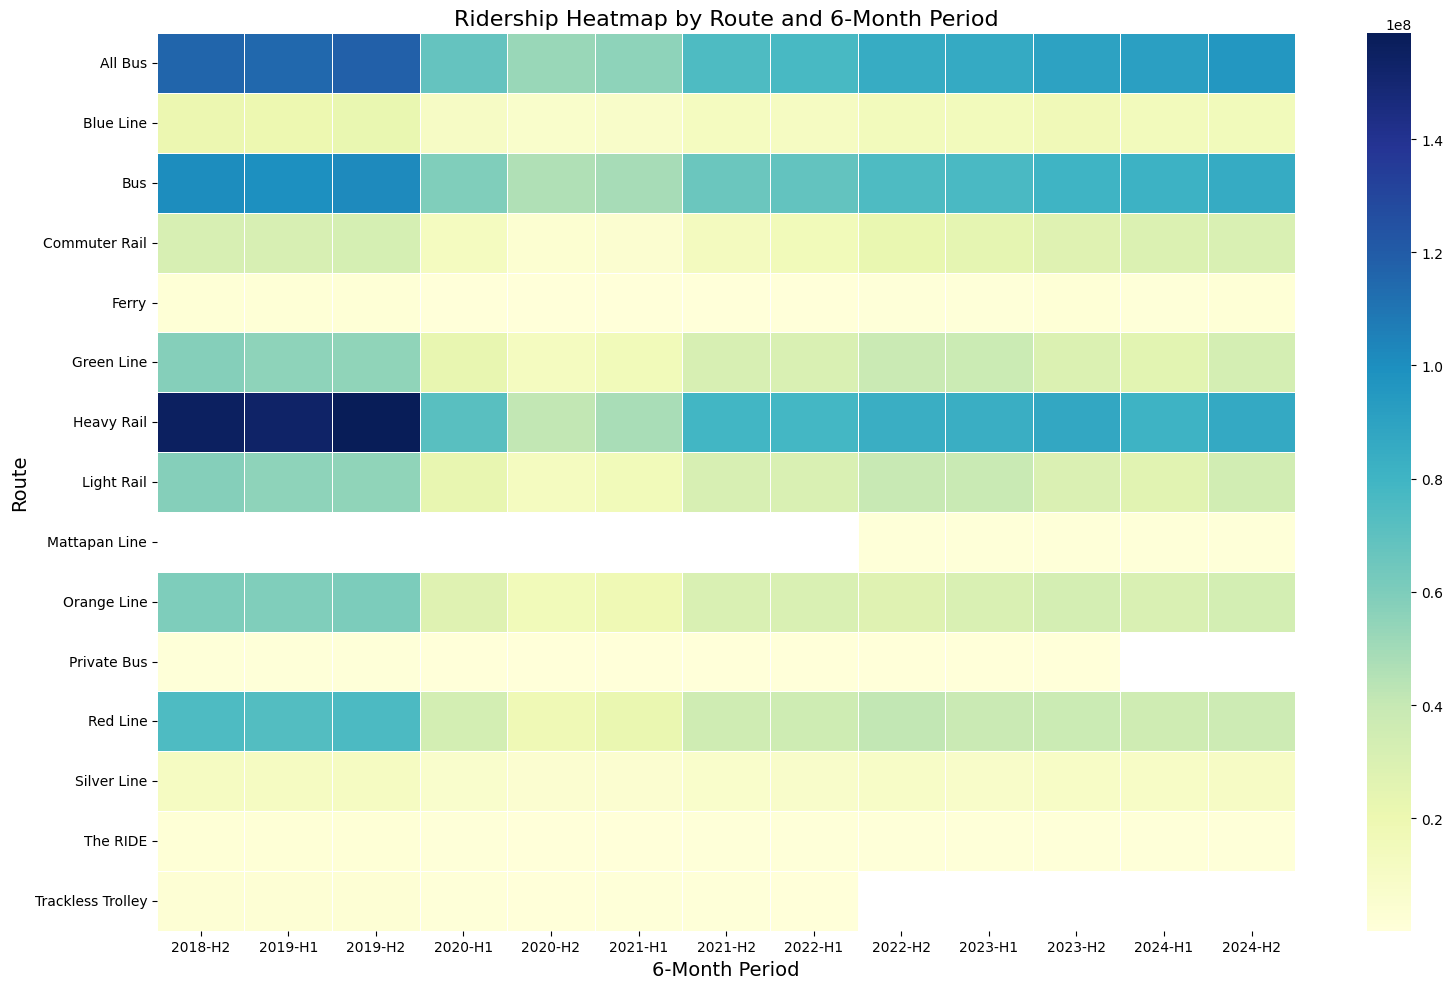

Percent Change in Average Ridership (Before vs After Pandemic):
pandemic_period    After Pandemic  Before Pandemic  Percent Change
route_or_line                                                     
Bus                  2.867018e+06     4.199458e+06      -31.728857
Silver Line          3.279794e+05     4.855364e+05      -32.450087
All Bus              3.230676e+06     4.846938e+06      -33.346048
Blue Line            5.227772e+05     8.798301e+05      -40.582028
Commuter Rail        7.726086e+05     1.332409e+06      -42.014152
The RIDE             4.391742e+04     7.609547e+04      -42.286422
Light Rail           1.176343e+06     2.341772e+06      -49.766971
Green Line           1.158491e+06     2.341772e+06      -50.529291
Heavy Rail           3.086457e+06     6.503589e+06      -52.542250
Orange Line          1.166980e+06     2.501450e+06      -53.347857
Ferry                6.020073e+04     1.294962e+05      -53.511584
Red Line             1.397681e+06     3.122309e+06      -55.23567

In [3]:
# Convert month_of_service to datetime
df['month_of_service'] = pd.to_datetime(df['month_of_service'])

# Create a 6-month period column
df['year'] = df['month_of_service'].dt.year
df['half_year'] = ((df['month_of_service'].dt.month - 1) // 6) + 1
df['period'] = df['year'].astype(str) + '-H' + df['half_year'].astype(str)

# Add a pandemic indicator (before/after 2020)
df['pandemic_period'] = df['month_of_service'].dt.year >= 2020
df['pandemic_period'] = df['pandemic_period'].map({True: 'After Pandemic', False: 'Before Pandemic'})

# Aggregate data by 6-month periods for each route
period_data = df.groupby(['period', 'route_or_line'])['ridership_total'].sum().reset_index()

# Create a pivot table for easier plotting
pivot_data = period_data.pivot(index='period', columns='route_or_line', values='ridership_total')

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
          '#9a6324', '#fffac8', '#800000', '#aaffc3']

# Plot ridership trends over 6-month periods for each route
plt.figure(figsize=(15, 10))
for i,route in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[route], label=route, marker='o', linewidth=2, color=colors[i])

plt.title('Ridership Trends by Route (6-Month Intervals)', fontsize=16)
plt.xlabel('6-Month Period', fontsize=14)
plt.ylabel('Total Ridership', fontsize=14)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compare pre-pandemic and post-pandemic ridership for each route
pre_post_comparison = df.groupby(['route_or_line', 'pandemic_period'])['ridership_total'].mean().reset_index()
pre_post_pivot = pre_post_comparison.pivot(index='route_or_line', columns='pandemic_period', values='ridership_total')

# Calculate the percent change (handle cases where 'Before Pandemic' might be missing)
if 'Before Pandemic' in pre_post_pivot.columns and 'After Pandemic' in pre_post_pivot.columns:
    pre_post_pivot['Percent Change'] = ((pre_post_pivot['After Pandemic'] - pre_post_pivot['Before Pandemic']) / 
                                      pre_post_pivot['Before Pandemic'] * 100)

# Plot the comparison as a bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='route_or_line', y='ridership_total', hue='pandemic_period', data=pre_post_comparison)
plt.title('Average Ridership Before and After Pandemic by Route', fontsize=16)
plt.xlabel('Route', fontsize=14)
plt.ylabel('Average Ridership per 6-Month Period', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Period', fontsize=12)
plt.tight_layout()
plt.show()

# Create a heatmap to visualize the changes over time for all routes
heatmap_data = pivot_data.T  # Transpose for better visualization
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt=".0f", linewidths=.5)
plt.title('Ridership Heatmap by Route and 6-Month Period', fontsize=16)
plt.ylabel('Route', fontsize=14)
plt.xlabel('6-Month Period', fontsize=14)
plt.tight_layout()
plt.show()

# Print the percent change table
if 'Percent Change' in pre_post_pivot.columns:
    print("Percent Change in Average Ridership (Before vs After Pandemic):")
    print(pre_post_pivot.sort_values('Percent Change', ascending=False))

## Analysis

From the above data we can see that most routes experienced a significant drop in ridership around 2020-H1, likely due to the COVID-19 pandemic. There's a gradual recovery in ridership across most routes from 2020-H2 onwards, though not reaching pre-pandemic levels for many routes.

**Route-Specific Observations**
- Heavy Rail shows the highest ridership consistently, especially pre-pandemic.

- All Bus and Bus routes follow Heavy Rail in terms of ridership volume.

- Blue Line, Commuter Rail, and Light Rail show moderate ridership levels.

- Ferry, Green Line, and Orange Line display lower but consistent ridership.

- The RIDE, Trackless Trolley, and Private Bus show the lowest ridership levels throughout the period.

**Temporal Patterns**
- Seasonal variations are visible in some routes, with slight dips often occurring in the first half of each year (H1).

- The recovery pattern is not uniform across all routes, with some bouncing back faster than others.

**Impact and Recovery**
- The pandemic's impact is most visible for Heavy Rail, All Bus, and Bus routes, showing the sharpest decline in 2020-H1.

- Some routes like Ferry and Trackless Trolley seem less affected, possibly due to their already lower ridership or essential nature.

- As of the most recent data point (2024-H2), most routes have not fully returned to their pre-pandemic ridership levels.